<a href="https://colab.research.google.com/github/zahraDehghanian97/VoxelMorph_Registration/blob/master/VoxelMorph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Medical Image Registration Using Voxelmorph
## Intelligent Analysis of Biomedical Images - Fall 2022
## Instructor: Dr. M. H. Rohban
## HW5 - Practical
## Student Name: Zahra Dehghanian
## Student ID: 401300417


In this assignment, you are going to train a voxelmorph network to do the unsupervised image registration task. You are going to use the [CHAOS MR T2 dataset](https://chaos.grand-challenge.org/), which is available to you from this google drive folder: [dataset](https://drive.google.com/drive/folders/1BGPa--fsmf8I5AeyFxa142N4lXpTqzIG?usp=sharing).
In this folder, you have access to 20 3D MR images of 20 different patients. Each image has its own number of slices (2D images) and consists of only one channel (gray-scaled images).

In the folder provided, you will have four different types of objects:


1.   the image itself
2.   the foreground mask (fgmask) of the image
3.   the label of the image
4.   the superpixels of the image

You have nothing to do with the superpixels; they are just in the folder. 



# Mount Drive
Mount your Google Drive here to get access to the data folder. If you don't know what is it and how to do it, use this [link](https://www.geeksforgeeks.org/download-anything-to-google-drive-using-google-colab/#:~:text=To%20import%20google%20drive%2C%20write,run%20it%20by%20Ctrl%2BEnter%20.&text=On%20running%20code%2C%20one%20blue,permission%20to%20access%20google%20drive.)

In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


# Installations

In [2]:
!pip install SimpleITK -q
!pip install sacred==0.7.5
!pip install voxelmorph -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 MB 16.8 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.3/92.3 KB 10.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.1/67.1 KB 8.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13723 sha256=e76cf402f4ae6b23f206fa46db79c6741d4366a4612fae5d86e6e4627d320789
  Stored in directory: /root/.cache/pip/wheels/56/ea/58/ead137b087d9e326852a851351d1debf4ada529b6ac0ec4e8c
  Created wheel for jsonpickle: filename=jsonpickle-0.9.6-py3-none-any.whl size=29480 sha256=0f500a60a3b45735ead129c22741151ed8188cf655c21d84dbb12476dcc7799e
  Stored in directory: /root/.cache/pip/wheels/ab/e7/04/52ff0efc2d7898b2c830b2bbadb1c8a376303934593aaa3638
Successfully built docopt jsonpickle
     ━━━━━━━━━

# Imports

In [3]:
import os
import numpy as np
from matplotlib import pyplot as plt
import glob
from tqdm import tqdm
import torch
os.environ['VXM_BACKEND'] = 'pytorch'
import voxelmorph as vxm
import neurite as ne
import SimpleITK as sitk
import pickle
import json
import time

# Reading Data

In [95]:
class Patient:
    def __init__(self, id_):
        self.id = id_
        self.frames_count = None
        self.fgmasks = None
        self.images = None
        self.labels = None

    def remove_without_labels(self):
        idx = []
        for frame_number, label in enumerate(self.labels):
            if label.max() > 0:
                idx.append(frame_number)
        self.frames_count = len(idx)
        self.fgmasks = self.fgmasks[idx]
        self.images = self.images[idx]
        self.labels = self.labels[idx]

    def get_z_slice(self,z):
      idx = []
      for frame_number in range(z):
        idx.append(frame_number)
      
      return self.images[idx].astype('float')/(3.5*255)

    def print_data_shapes(self):
        print('patient ', self.id)
        print('fmgasks: ', self.fgmasks.shape)
        print('images: ', self.images.shape)
        print('lables: ', self.labels.shape)
        print('-' * 30)

    def plot(self, frame_number):
        fig , (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 15))
        ax1.imshow(self.images[frame_number], origin='lower', cmap='gray')
        ax2.imshow(self.fgmasks[frame_number], origin='lower', cmap='gray')
        ax3.imshow(self.labels[frame_number], origin='lower', cmap='gray')
        ax1.set_title("image")
        ax2.set_title("fgmask")
        ax3.set_title("lablel")


def create_patients(ids):
    patients = {}
    for id_ in ids:
        patients[id_] = Patient(id_)
    return patients


In [96]:
def save_patients_images(path):
    images = {}
    for id, patient in patients.items():
        images[id] = patient.images
    with open(path, 'wb') as f:
        pickle.dump(images, f)


def save_patients_superpixs(path):
    superpixs = {}
    for id, patient in patients.items():
        superpixs[id] = patient.superpixs
    with open(path, 'wb') as f:
        pickle.dump(superpixs, f)


def save_patients_labels(path):
    labels = {}
    for id, patient in patients.items():
        labels[id] = patient.labels
    with open(path, 'wb') as f:
        pickle.dump(labels, f)


def read_nii_bysitk(input_fid, peel_info=False):
    """ read nii to numpy through simpleitk
        peelinfo: taking direction, origin, spacing and metadata out
    """
    img_obj = sitk.ReadImage(input_fid)
    img_np = sitk.GetArrayFromImage(img_obj)
    if peel_info:
        info_obj = {
            "spacing": img_obj.GetSpacing(),
            "origin": img_obj.GetOrigin(),
            "direction": img_obj.GetDirection(),
            "array_size": img_np.shape
        }
        return img_np, info_obj
    else:
        return img_np

In [97]:
patient_ids = [1, 2, 3, 5, 8, 10, 13, 15, 19, 20, 21, 22, 31, 32, 33, 34, 36, 37, 38, 39]
project_root = "/content/gdrive/MyDrive/IABI-F2022/"
data_root = '/content/gdrive/MyDrive/IABI-F2022/chaos_MR_T2_normalized/'

patients = create_patients(patient_ids)
for path in tqdm(glob.iglob(data_root + '**/*.nii.gz', recursive=True), desc="Reading"):
    id_ = int(path.split('_')[-1].split('.')[0])
    patient = patients.get(id_)
    obj = read_nii_bysitk(path)
    if 'fgmask' in path:
        patient.fgmasks = obj
        patient.frames_count = obj.shape[0]
    elif 'image' in path:
        patient.images = obj
    elif 'label' in path:
        patient.labels = obj

Reading: 80it [00:04, 17.89it/s]


# Visualization

patient  1
fmgasks:  (37, 256, 256)
images:  (37, 256, 256)
lables:  (37, 256, 256)
------------------------------
patient  2
fmgasks:  (31, 256, 256)
images:  (31, 256, 256)
lables:  (31, 256, 256)
------------------------------
patient  3
fmgasks:  (36, 256, 256)
images:  (36, 256, 256)
lables:  (36, 256, 256)
------------------------------


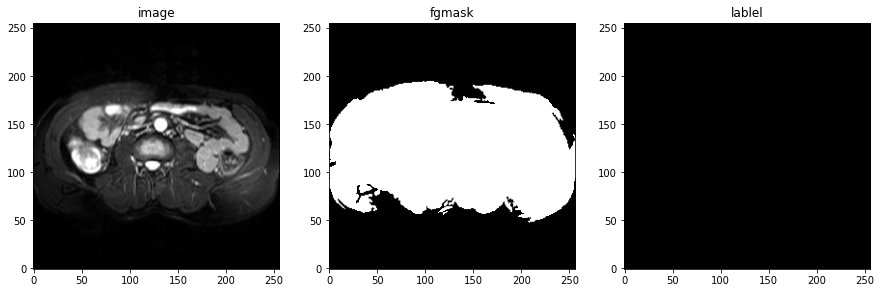

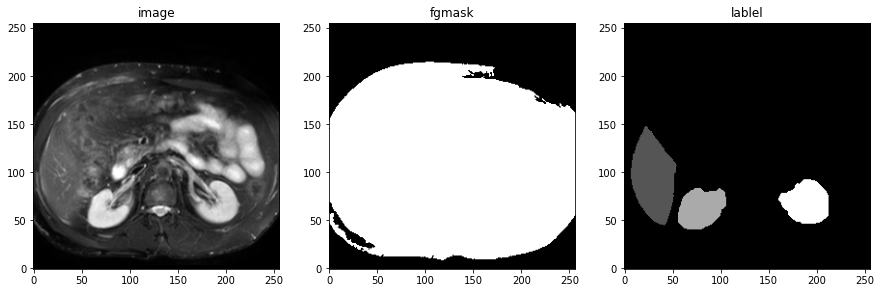

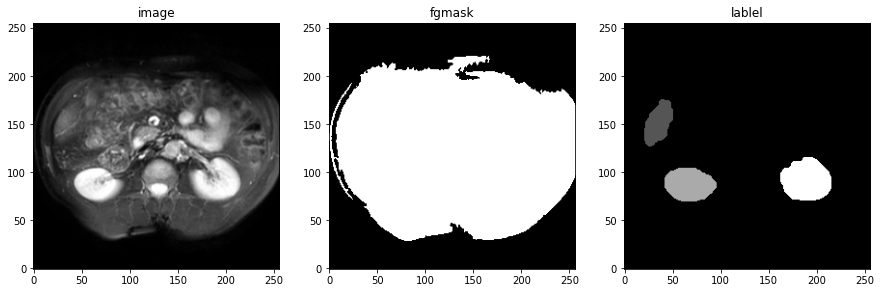

In [98]:
for i in [1, 2, 3]:
  patient = patients[i]
  patient.print_data_shapes()
  patient.plot(10)

# Data Set and Data Loader

get data train into standard np array of size [N, X, Y, Z]

In [99]:
c = []
for i in patient_ids :
  patients[i].remove_without_labels()
  c.append(patients[i].frames_count)

min_c = min(c)
all_data = []
for i in patient_ids :
  all_data.append(patients[i].get_z_slice(min_c))

reshape_all_data = []
for row in all_data:
  reshape_all_data.append(list(np.array(row).T))

reshape_all_data = np.array(reshape_all_data)
train_data = reshape_all_data[:-1]
val_data = np.array([reshape_all_data[-1]])

print(train_data.shape)
print(val_data.shape)

(19, 256, 256, 22)
(1, 256, 256, 22)


In [100]:
BATCH_SIZE_ = 1

In [101]:
def vxm_data_generator(x_data, batch_size):
    """
    generator that takes in data of size [N, X, Y, Z], and yields data for our vxm model

    Note that we need to provide numpy data for each input, and each output

    inputs:  moving_image [bs, x, y, z, 1], fixed_image [bs, x, y, z, 1]
    outputs: moved_image  [bs, x, y, z, 1], zeros [bs, x, y, z, 2]
    """
    

    # preliminary sizing
    vol_shape = x_data.shape[1:] # extract data shape
    ndims = len(vol_shape)
    
    # prepare a zero array the size of the deformation
    # we'll explain this below
    zero_phi = np.zeros([batch_size, *vol_shape, ndims])
    
    while True:
        # prepare inputs:
        # images need to be of the size [batch_size, H, W, 1]
        idx1 = np.random.randint(0, x_data.shape[0], size=batch_size)
        moving_images = x_data[idx1,:,:,:, np.newaxis]
        idx2 = np.random.randint(0, x_data.shape[0], size=batch_size)
        fixed_images = x_data[idx2, :,:,:, np.newaxis]
        inputs = [moving_images, fixed_images]
        
        # prepare outputs (the 'true' moved image):
        # of course, we don't have this, but we know we want to compare 
        # the resulting moved image with the fixed image. 
        # we also wish to penalize the deformation field. 
        outputs = [fixed_images, zero_phi]
        
        yield inputs, outputs
     


# Data Loader Visualization

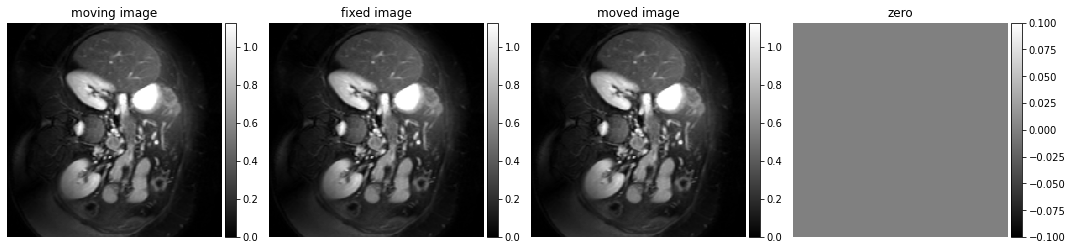

(<Figure size 1080x270 with 8 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fd8b6dd65b0>,
       dtype=object))

In [102]:
# create the data generator
train_generator = vxm_data_generator(train_data, BATCH_SIZE_)

# visualize a sample
input_sample, output_sample = next(train_generator)
slices_2d = [f[0, :, :, 10, 0] for f in input_sample + output_sample]
titles = ['moving image', 'fixed image', 'moved image', 'zero']
ne.plot.slices(slices_2d, titles=titles, cmaps=['gray'], do_colorbars=True)

# Volxelmorph

In [106]:

# configure unet features 
nb_features = [
    [32, 32, 32, 32],         # encoder features
    [32, 32, 32, 32, 32, 16]  # decoder features
]

# build model using VxmDense
inshape = train_data.shape[1:]
vxm_model = vxm.networks.VxmDense(inshape, nb_features, int_steps=0)
     

print('input shape: ', ', '.join([str(t.shape) for t in vxm_model.inputs]))
print('output shape:', ', '.join([str(t.shape) for t in vxm_model.outputs]))
     
# input shape:  (None, 256, 256, 22, 1), (None, 256, 256, 22, 1)
# output shape: (None, 256, 256, 22, 1), (None, 256, 256, 22, 3)

# voxelmorph has a variety of custom loss classes
losses = [vxm.losses.MSE().loss, vxm.losses.Grad('l2').loss]

# usually, we have to balance the two losses by a hyper-parameter
lambda_param = 0.05
loss_weights = [1, lambda_param]
     

vxm_model.compile(optimizer='Adam', loss=losses, loss_weights=loss_weights)
     

AttributeError: ignored

In [103]:
nb_features = [
    [32, 32, 32, 32],         # encoder features
    [32, 32, 32, 32, 32, 16]  # decoder features
]


vol_shape = train_data.shape[1:] # extract data shape

# unet
vxm_model = vxm.networks.VxmDense(vol_shape, nb_features, int_steps=0)

# losses and loss weights
losses = ['mse', vxm.losses.Grad('l2').loss]
loss_weights = [1, 0.01]

/usr/local/lib/python3.8/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [104]:
vxm_model.compile(optimizer=tf.keras.optimizers.Adam(lr=1e-4), loss=losses, loss_weights=loss_weights)

AttributeError: ignored

In [ ]:
hist = vxm_model.fit_generator(train_generator, epochs=5, steps_per_epoch=5, verbose=2);

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/5
5/5 - 13s - loss: 0.0068 - transformer_loss: 0.0068 - flow_loss: 9.9954e-08
Epoch 2/5
5/5 - 10s - loss: 0.0069 - transformer_loss: 0.0069 - flow_loss: 1.1938e-06
Epoch 3/5
5/5 - 10s - loss: 0.0072 - transformer_loss: 0.0072 - flow_loss: 6.1821e-06
Epoch 4/5
5/5 - 10s - loss: 0.0070 - transformer_loss: 0.0070 - flow_loss: 2.6120e-05
Epoch 5/5
5/5 - 10s - loss: 0.0076 - transformer_loss: 0.0076 - flow_loss: 7.4557e-05


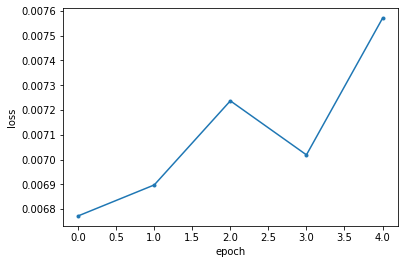

In [ ]:
# as before, let's visualize what happened
plot_history(hist)

In [ ]:
# create the validation data generator
val_generator = vxm_data_generator(x_val, batch_size = 1)
val_input, _ = next(val_generator)

In [ ]:
# prediction
val_pred = vxm_model.predict(val_input)

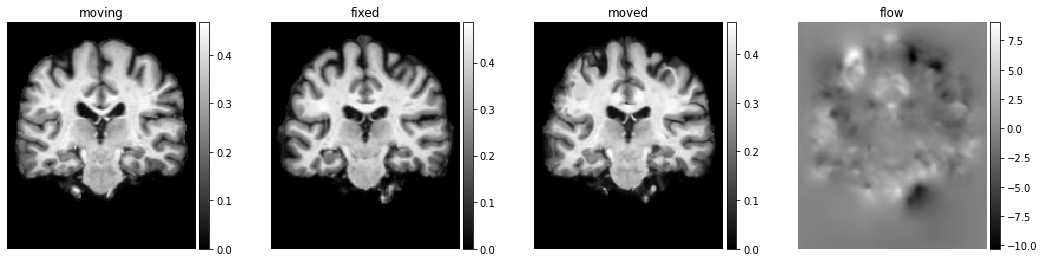

In [ ]:
# visualize registration
images = [img[0, :, :, 0] for img in val_input + val_pred] 
titles = ['moving', 'fixed', 'moved', 'flow']
ne.plot.slices(images, titles=titles, cmaps=['gray'], do_colorbars=True);

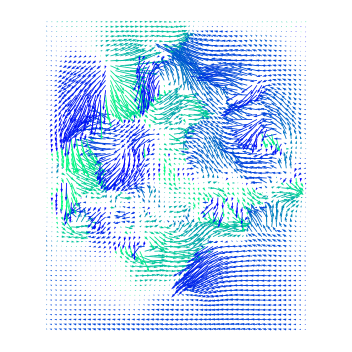

In [ ]:
# visualize flow
flow = val_pred[1].squeeze()[::3,::3]
ne.plot.flow([flow], width=5);

In [ ]:
# unet
vxm_model = vxm.networks.VxmDense(vol_shape, nb_features, int_steps=0)

# losses and loss weights
losses = ['mse', vxm.losses.Grad('l2').loss]
loss_weights = [1, 0.01]

In [ ]:
vxm_model.compile(optimizer=tf.keras.optimizers.Adam(lr=1e-4), loss=losses, loss_weights=loss_weights)

# Model and Optimizer

# Spatial Transformer


# Trianing
In the following sections, you may read the data, get familiar with it, and implement a Pytorch code that trains a Voxelmorph network to register a moving image (2D) to a fixed image (also 2D). 

1.   Do your training with 19 images (all except the last one which has the ID 39; we need it for the testing part)
2.   You have to train your network in an unsupervised manner (don't use labels in training)
3.   Use voxelmorph library; you don't need to implement the model yourself
4.   Use both similarity and smoothness losses. You may use trial and error to determine the best combination of these losses.
5. Plot the training loss  
6. Visualize your model's ability to register images by plotting at least 10 (moving, moved, fixed) triplets
6.   You may use creative approaches to improve your results (e.g., train bidirectional, train with not adjacent slices, etc.)


# Testing

1.   Pick the patient 39 image and label
2.   Find the range of slices in which all slices have a labeled organ (slices whose label is not blank)
3.   Pick the middle slice in the range mentioned above
4.   Propagate its label to the whole volume using your trained model (using the displacement fields)
5.   Visualize your results. Plot propagated labels and actual labels in order to do an intuitive comparison
6.   Take the dice score between the propagated labels and the actual labels of slices. Report them one by one. Take the average of those. Report this number as the final metric of evaluation of your model.




